In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()
sys.path.insert(0,'..')
%matplotlib inline

In [55]:
def smape(y, y_hat, eps=0.1):
    summ = np.maximum(np.abs(y) + np.abs(y_hat) + eps, 0.5 + eps)
    smape = 2. * np.abs(y_hat - y) / summ
    return smape

In [56]:
def regr_metrics(y, y_hat):
    assert y.shape == y_hat.shape
    return {
        'mse': np.mean(np.square(y - y_hat)),
        'mae': np.mean(np.abs(y - y_hat)),
        'smape': np.mean(smape(y, y_hat))
    }

In [77]:
def smooth(x,w=0.99):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

### Dataset
Experiments are conducted on the sm1 dataset that can be found [here](https://drive.google.com/drive/u/0/folders/0B3B22Hd5PMxSaVpsYmRHU2ZJYWc). The task is to predict the temperature of the sensor in the living room of the next 24 hours, given the previous 24 hours observation of each feature of the dataset.

In [87]:
dataset = pd.read_csv('../data/benchmark/sm1_2010.csv', index_col=0)
dataset.head()

,temperature_comedor_sensor,temperature_habitacion_sensor,weather_temperature,co2_comedor_sensor,co2_habitacion_sensor,humedad_comedor_sensor,humedad_habitacion_sensor,lighting_comedor_sensor,lighting_habitacion_sensor,precipitacion,...,meteo_exterior_sol_oest,meteo_exterior_sol_est,meteo_exterior_sol_sud,meteo_exterior_piranometro,exterior_entalpic_1,exterior_entalpic_2,exterior_entalpic_turbo,temperature_exterior_sensor,humedad_exterior_sensor,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2012-03-13,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,...,9690.24,12604.20,95436.8,758.880,0,0,0,18.1150,48.3750,2.0
2012-03-13,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,...,11022.00,10787.20,95436.8,762.069,0,0,0,18.4147,47.8080,2.0
2012-03-13,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,...,13960.50,9669.63,95398.6,766.251,0,0,0,18.8533,47.4320,2.0
2012-03-13,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,...,18511.20,9648.13,95360.3,766.037,0,0,0,19.2907,47.0240,2.0
2012-03-13,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,...,26349.00,9208.32,95354.9,762.743,0,0,0,19.7400,45.4743,2.0


In [89]:
dataset.columns.tolist()

['temperature_comedor_sensor',
 'temperature_habitacion_sensor',
 'weather_temperature',
 'co2_comedor_sensor',
 'co2_habitacion_sensor',
 'humedad_comedor_sensor',
 'humedad_habitacion_sensor',
 'lighting_comedor_sensor',
 'lighting_habitacion_sensor',
 'precipitacion',
 'meteo_exterior_crepusculo',
 'meteo_exterior_viento',
 'meteo_exterior_sol_oest',
 'meteo_exterior_sol_est',
 'meteo_exterior_sol_sud',
 'meteo_exterior_piranometro',
 'exterior_entalpic_1',
 'exterior_entalpic_2',
 'exterior_entalpic_turbo',
 'temperature_exterior_sensor',
 'humedad_exterior_sensor',
 'day_of_week']

In [90]:
dataset.shape

(4137, 22)

### Training and test split
The dataset is split in training and testset. The testset is made of the 20% of the complete dataset by sampling uniformly random day, while the training set is made of the remaning observation.

#### Model
The chosen model is a seq2seq model, with a single layer GRU unit with residual wrapper and dropout. The seq2seq is equipped with an attention mechanism in the encoder, that attends wrt the inputs as in [DARNN](https://arxiv.org/abs/1704.02971), which is implemented in ntsa/models/blocks as InputAttention.
In the kaf variation we add a Kaf non linearity after the memory layer as:

$$
x = softmax(k(x) + x)
$$

Where Kaf is implemented at ntsa/utils/tf_utils.py Kaf, with a dictionary $D=(-1,1)$ of 20 elements, $\gamma = 0.0315$ and the weights initialized via Ridge regression, the chosen kernel is a 1D rbf kernel, and the $\alpha$ is of size 128 units, the same as the size of the internal state of the gru cell.

```python
class InputAttention(Attention):

    def __init__(self,
                 output_shape,
                 memory,
                 name='input_attention',
                 use_bias=False,
                 alpha=0):
        super(InputAttention, self).__init__(
            output_shape=output_shape,
            memory=tf.transpose(memory, (0, 2, 1)),
            name=name,
        )
        if alpha:
            k = Kaf(input_shape=alpha)
            self._act = lambda x: tf.nn.softmax(k(x) + x)
        else:
            self._act = tf.nn.softmax
        self._memory_layer = tf.layers.Dense(units=1, use_bias=use_bias, name='memory', activation=None)
        self._input_shape = memory.get_shape()[-1]

    def apply(self, query, state, t):
        # batch_size, input_shape, cell_size + seq_len
        x = tf.concat([tf.tile(tf.expand_dims(state, axis=1), (1, self._input_shape, 1)), self._memory], axis=2)
        x = self._memory_layer(x)
        x = tf.squeeze(x, axis=2)
        alpha = self._act(x)
        x_tilde = tf.multiply(alpha, query)
        return x_tilde, state
```

### Training
Each network is trained for 100000 steps. Training parameters can be found in ntsa/config.gin. We tracked several loss function as well ad the norm of the gradient, at each training step.

In [70]:
df_kaf = pd.read_csv('../logs/seq2seq/ntsa-2018-11-25-21-48-27/train/results.csv')
df = pd.read_csv('../logs/seq2seq/ntsa-2018-11-25-21-49-54/train/results.csv')

In [71]:
df.head()

,loss,reg,norm,mse,mae,smape,rmse
0,1.790945,0.000002,3.500812,1.176875,1.044435,1.790943,1.044435
1,0.329209,0.000239,24.580881,0.019837,0.112467,0.328969,0.112467
2,0.378471,0.001690,14.852942,0.250215,0.483331,0.376780,0.483331
3,0.392411,0.001307,29.092663,0.226930,0.395704,0.391104,0.395704
4,0.531758,0.000422,21.874247,0.124814,0.268285,0.531336,0.268285


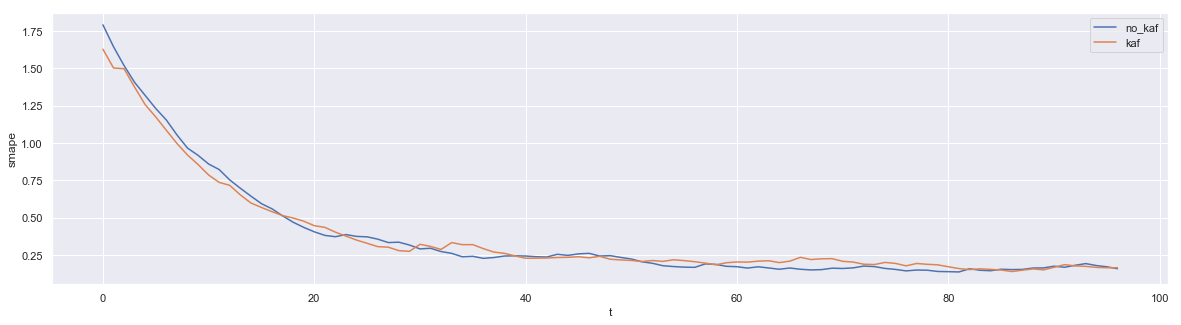

In [83]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.loss.values, .9))
ax.plot(smooth(df_kaf.loss.values, .9))
plt.ylabel('smape')
plt.xlabel('t')
plt.legend(['no_kaf','kaf'])

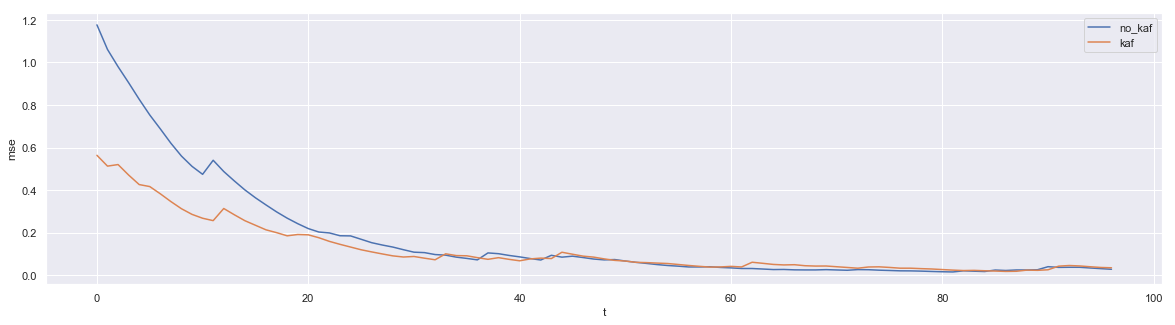

In [82]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.mse.values, .9))
ax.plot(smooth(df_kaf.mse.values, .9))
plt.ylabel('mse')
plt.xlabel('t')
plt.legend(['no_kaf','kaf'])

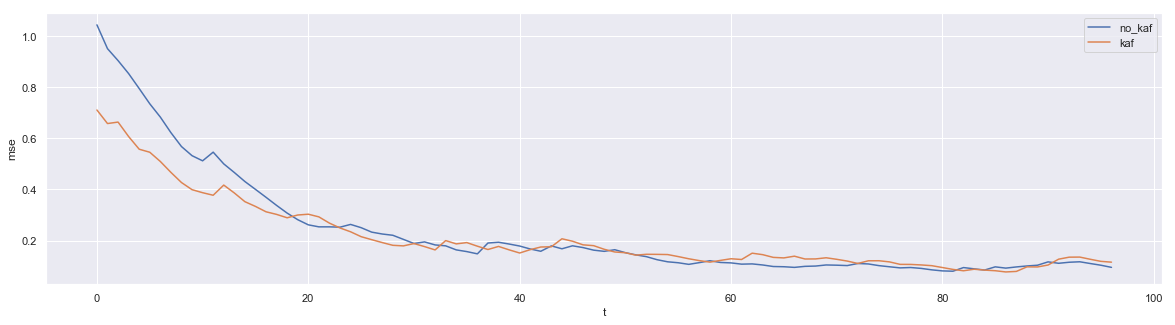

In [81]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.mae.values, .9))
ax.plot(smooth(df_kaf.mae.values, .9))
plt.ylabel('mse')
plt.xlabel('t')
plt.legend(['no_kaf','kaf'])

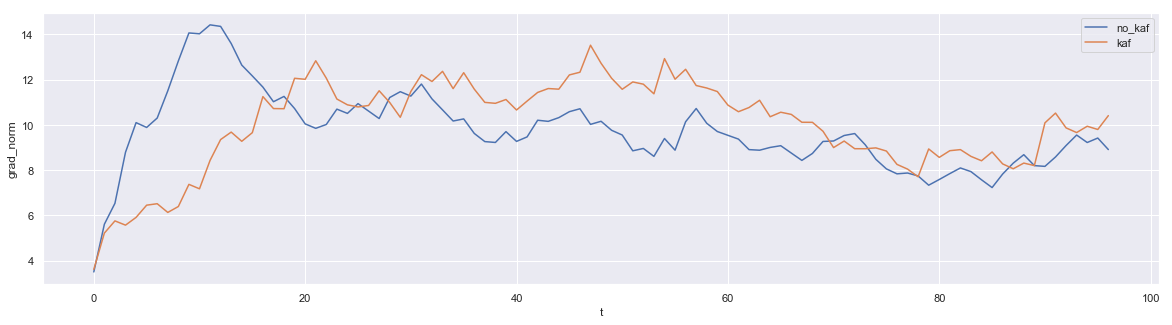

In [80]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.norm.values, .90))
ax.plot(smooth(df_kaf.norm.values, .90))
plt.ylabel('grad_norm')
plt.xlabel('t')
plt.legend(['no_kaf','kaf'])

### Test and evaluation
A complete test evaluation is recored every 5000 steps and here we report the last one, for each metric.

In [98]:
df_kaf = pd.read_csv('../logs/seq2seq/ntsa-2018-11-25-21-48-27/report/9844_report.csv', index_col=0)
df = pd.read_csv('../logs/seq2seq/ntsa-2018-11-25-21-49-54/report/9841_report.csv', index_col=0)

In [99]:
regr_metrics(*np.split(df.values,2,axis=1))

{'mae': 0.3625242222222218,
 'mse': 0.1635553963706665,
 'smape': 0.015606924210690907}

In [100]:
regr_metrics(*np.split(df_kaf.values,2,axis=1))

{'mae': 0.1842467777777775,
 'mse': 0.053083009566777764,
 'smape': 0.007999968081963597}

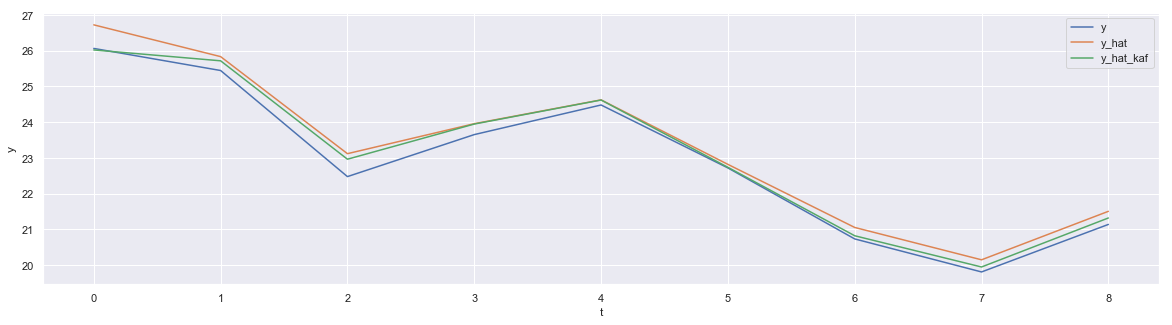

In [101]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df.y.values)
ax.plot(df.y_hat.values)
ax.plot(df_kaf.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y','y_hat', 'y_hat_kaf'])

### Conclusion
We notice that we beat the state of the art (yuhu)